In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("cumulative.csv")

In [3]:
df.shape

(9564, 50)

In [4]:
df.head()

,loc_rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [5]:
df.columns

Index(['loc_rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc_rowid          9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2747 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [7]:
df = df.rename(columns={'kepid':'KepID',
'kepoi_name':'KOIName',
'kepler_name':'KeplerName',
'koi_disposition':'Exoplanet_Archive_Disposition',
'koi_pdisposition':'Disposition_Using_KeplerData',
'koi_score':'DispositionScore',
'koi_fpflag_nt':'NotTransit_LikeFPFlag',
'koi_fpflag_ss':'StellarEclipse_FP_Flag',
'koi_fpflag_co':'CentroidOffsetFPFlag',
'koi_fpflag_ec':'EphemerisMatchIndicatesContaminationFPFlag',
'koi_period':'OrbitalPeriod_days',
'koi_period_err1':'OrbitalPeriodUpper_days',
'koi_period_err2':'OrbitalPeriodLower_days',
'koi_time0bk':'TransitEpoch_BKJD',
'koi_time0bk_err1':'TransitEpoch_Lower',
'koi_time0bk_err2':'TransitEpoch_Upper',
'koi_impact':'ImpactParameter',
'koi_impact_err1':'ImpactParameter_Lower',
'koi_impact_err2':'ImpactParameter_Upper',
'koi_duration':'TransitDuration_hrs',
'koi_duration_err1':'TransitDuration_Lower',
'koi_duration_err2':'TransitDuration_Upper',
'koi_depth':'TransitDepth_ppm',
'koi_depth_err1':'TransitDepth_Lower',
'koi_depth_err2':'TransitDepth_Upper',
'koi_prad':'PlanetaryRadius_Earthradii',
'koi_prad_err1':'PlanetaryRadius_Lower',
'koi_prad_err2':'PlanetaryRadius_Upper',
'koi_teq':'EquilibriumTemperature_K',
'koi_teq_err1':'EquilibriumTemperature_Lower',
'koi_teq_err2':'EquilibriumTemperature_Upper',
'koi_insol':'InsolationFlux_Earthflux',
'koi_insol_err1':'InsolationFlux_Lower',
'koi_insol_err2':'InsolationFlux_Upper',
'koi_model_snr':'TransitSignal_to_Noise',
'koi_tce_plnt_num':'TCE_PlanetNumber',
'koi_tce_delivname':'TCE_DeliverName',
'koi_steff':'StellarEffectiveTemperature_K',
'koi_steff_err1':'StellarEffectiveTemp_Lower',
'koi_steff_err2':'StellarEffectiveTemp_Upper',
'koi_slogg':'StellarSurfaceGravity',
'koi_slogg_err1':'Stellar_SurfaceGravity_Lower',
'koi_slogg_err2':'Stellar_SurfaceGravity_Upper',
'koi_srad':'StellarRadius_Solarradii',
'koi_srad_err1':'StellarRadius_Lower',
'koi_srad_err2':'StellarRadius_Upper',
'ra':'RA_deg',
'dec':'Dec_deg',
'koi_kepmag':'Kepler_band[mag]'
})

## handling missing values

In [8]:
df.isnull().sum()

loc_rowid                                        0
KepID                                            0
KOIName                                          0
KeplerName                                    6817
Exoplanet_Archive_Disposition                    0
Disposition_Using_KeplerData                     0
DispositionScore                              1510
NotTransit_LikeFPFlag                            0
StellarEclipse_FP_Flag                           0
CentroidOffsetFPFlag                             0
EphemerisMatchIndicatesContaminationFPFlag       0
OrbitalPeriod_days                               0
OrbitalPeriodUpper_days                        454
OrbitalPeriodLower_days                        454
TransitEpoch_BKJD                                0
TransitEpoch_Lower                             454
TransitEpoch_Upper                             454
ImpactParameter                                363
ImpactParameter_Lower                          454
ImpactParameter_Upper          

In [9]:
df.drop(columns=[
    'KepID',
    'KOIName',
    'KeplerName',
    'Disposition_Using_KeplerData',          
    'NotTransit_LikeFPFlag',                 
    'StellarEclipse_FP_Flag',                
    'CentroidOffsetFPFlag',                  
    'EphemerisMatchIndicatesContaminationFPFlag',
    'TCE_PlanetNumber',
    'TCE_DeliverName',
    'RA_deg',
    'Dec_deg',
    'DispositionScore',
    'EquilibriumTemperature_Lower',
    'EquilibriumTemperature_Upper',
    'loc_rowid'
], inplace=True)

In [10]:
df.shape

(9564, 34)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Exoplanet_Archive_Disposition  9564 non-null   object 
 1   OrbitalPeriod_days             9564 non-null   float64
 2   OrbitalPeriodUpper_days        9110 non-null   float64
 3   OrbitalPeriodLower_days        9110 non-null   float64
 4   TransitEpoch_BKJD              9564 non-null   float64
 5   TransitEpoch_Lower             9110 non-null   float64
 6   TransitEpoch_Upper             9110 non-null   float64
 7   ImpactParameter                9201 non-null   float64
 8   ImpactParameter_Lower          9110 non-null   float64
 9   ImpactParameter_Upper          9110 non-null   float64
 10  TransitDuration_hrs            9564 non-null   float64
 11  TransitDuration_Lower          9110 non-null   float64
 12  TransitDuration_Upper          9110 non-null   f

In [12]:
df.head()

,Exoplanet_Archive_Disposition,OrbitalPeriod_days,OrbitalPeriodUpper_days,OrbitalPeriodLower_days,TransitEpoch_BKJD,TransitEpoch_Lower,TransitEpoch_Upper,ImpactParameter,ImpactParameter_Lower,ImpactParameter_Upper,...,StellarEffectiveTemperature_K,StellarEffectiveTemp_Lower,StellarEffectiveTemp_Upper,StellarSurfaceGravity,Stellar_SurfaceGravity_Lower,Stellar_SurfaceGravity_Upper,StellarRadius_Solarradii,StellarRadius_Lower,StellarRadius_Upper,Kepler_band[mag]
0,CONFIRMED,9.488036,2.780000e-05,-2.780000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347
1,CONFIRMED,54.418383,2.480000e-04,-2.480000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347
2,CANDIDATE,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,...,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,15.436
3,FALSE POSITIVE,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,...,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,15.597
4,CONFIRMED,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,...,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,15.509


In [13]:
df.isnull().sum()

Exoplanet_Archive_Disposition      0
OrbitalPeriod_days                 0
OrbitalPeriodUpper_days          454
OrbitalPeriodLower_days          454
TransitEpoch_BKJD                  0
TransitEpoch_Lower               454
TransitEpoch_Upper               454
ImpactParameter                  363
ImpactParameter_Lower            454
ImpactParameter_Upper            454
TransitDuration_hrs                0
TransitDuration_Lower            454
TransitDuration_Upper            454
TransitDepth_ppm                 363
TransitDepth_Lower               454
TransitDepth_Upper               454
PlanetaryRadius_Earthradii       363
PlanetaryRadius_Lower            363
PlanetaryRadius_Upper            363
EquilibriumTemperature_K         363
InsolationFlux_Earthflux         321
InsolationFlux_Lower             321
InsolationFlux_Upper             321
TransitSignal_to_Noise           363
StellarEffectiveTemperature_K    363
StellarEffectiveTemp_Lower       468
StellarEffectiveTemp_Upper       483
S

In [14]:
num_cols = df.select_dtypes(include=['float64','int64']).columns

imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])


In [15]:
df.isnull().sum()

Exoplanet_Archive_Disposition    0
OrbitalPeriod_days               0
OrbitalPeriodUpper_days          0
OrbitalPeriodLower_days          0
TransitEpoch_BKJD                0
TransitEpoch_Lower               0
TransitEpoch_Upper               0
ImpactParameter                  0
ImpactParameter_Lower            0
ImpactParameter_Upper            0
TransitDuration_hrs              0
TransitDuration_Lower            0
TransitDuration_Upper            0
TransitDepth_ppm                 0
TransitDepth_Lower               0
TransitDepth_Upper               0
PlanetaryRadius_Earthradii       0
PlanetaryRadius_Lower            0
PlanetaryRadius_Upper            0
EquilibriumTemperature_K         0
InsolationFlux_Earthflux         0
InsolationFlux_Lower             0
InsolationFlux_Upper             0
TransitSignal_to_Noise           0
StellarEffectiveTemperature_K    0
StellarEffectiveTemp_Lower       0
StellarEffectiveTemp_Upper       0
StellarSurfaceGravity            0
Stellar_SurfaceGravi

### Encoding Target Labels

In [16]:
df['Disposition_encoded'] = df['Exoplanet_Archive_Disposition'].map({
    'CONFIRMED': 0,
    'FALSE POSITIVE': 1,
    'CANDIDATE': 2
})


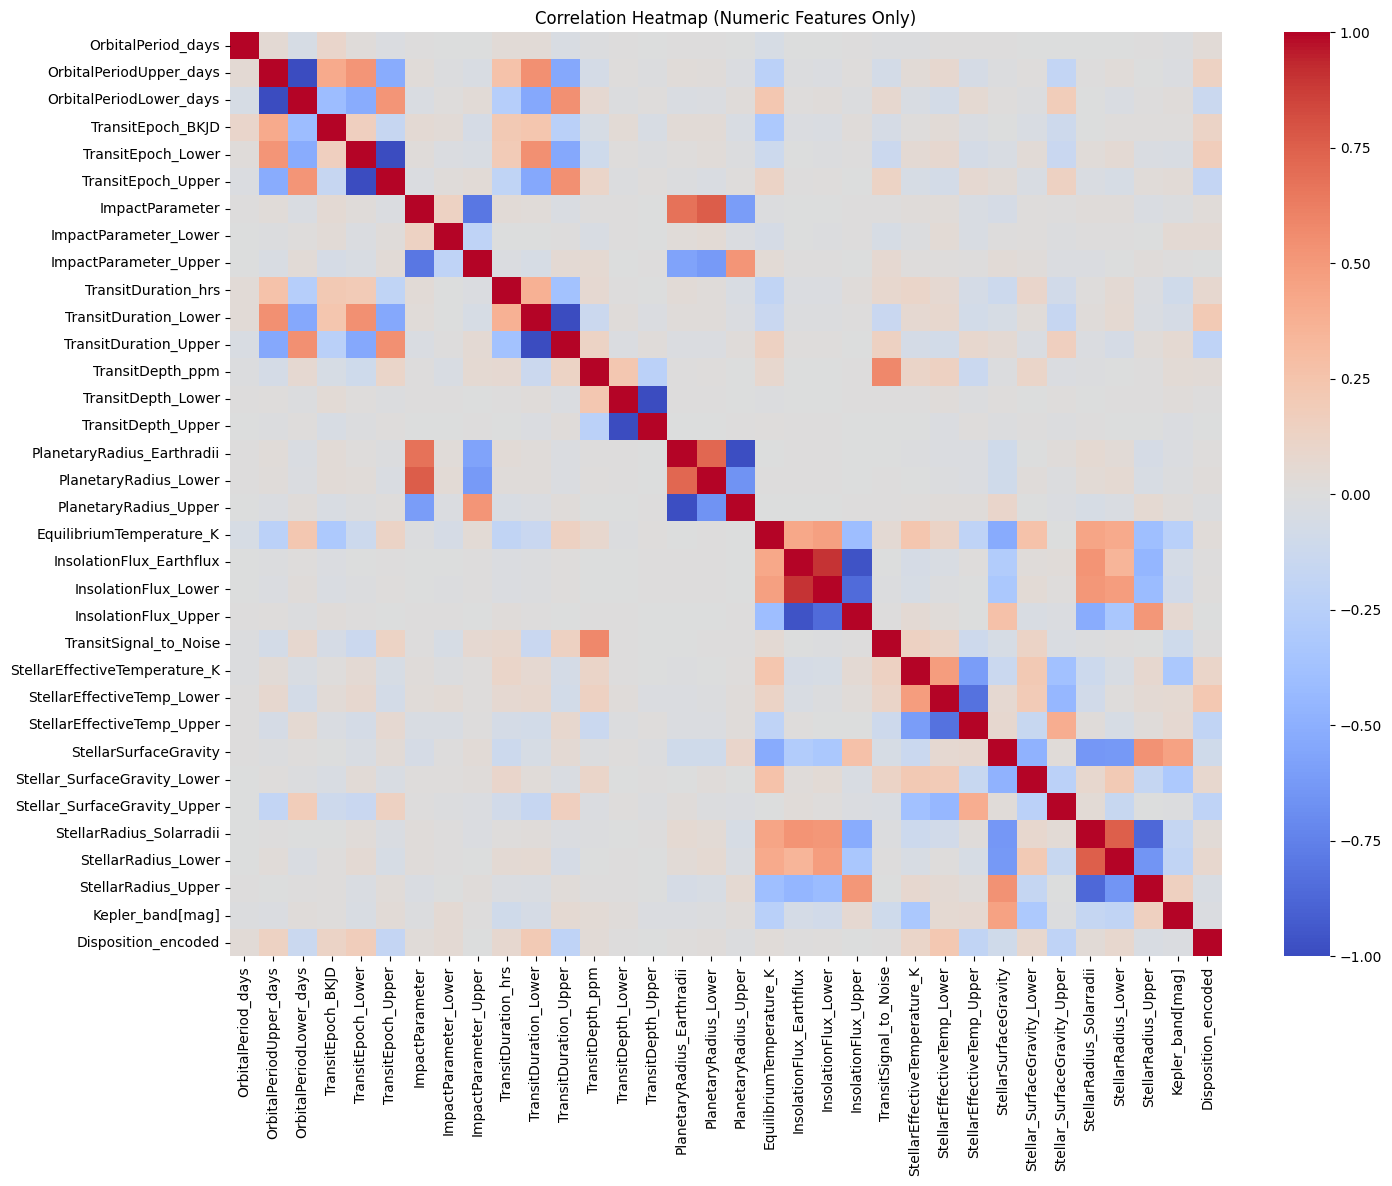

In [17]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


## Feature Engineering and dropping columns

In [18]:
# creating new features
df['orbital_period_uncertainty'] = df['OrbitalPeriodUpper_days'] - df['OrbitalPeriodLower_days']
df['transit_duration_uncertainty'] = df['TransitDuration_Upper'] - df['TransitDuration_Lower']
df['transit_depth_uncertainty'] = df['TransitDepth_Upper'] - df['TransitDepth_Lower']
df['planetary_radius_uncertainty'] = df['PlanetaryRadius_Upper'] - df['PlanetaryRadius_Lower']
df['insolation_flux_uncertainty'] = df['InsolationFlux_Upper'] - df['InsolationFlux_Lower']
df['impact_parameter_uncertainty'] = df['ImpactParameter_Upper'] - df['ImpactParameter_Lower']
df['stellar_temp_uncertainty'] = df['StellarEffectiveTemp_Upper'] - df['StellarEffectiveTemp_Lower']
df['stellar_gravity_uncertainty'] = df['Stellar_SurfaceGravity_Upper'] - df['Stellar_SurfaceGravity_Lower']

df['stellar_radius_uncertainty'] = df['StellarRadius_Upper'] - df['StellarRadius_Lower']
df['transit_epoch_uncertainty'] = df['TransitEpoch_Upper'] - df['TransitEpoch_Lower']
df['transit_frequency'] = 1 / df['OrbitalPeriod_days']
df['planet_to_star_radius_ratio'] = df['PlanetaryRadius_Earthradii'] / df['StellarRadius_Solarradii']
df['planet_to_star_density_ratio'] = (df['PlanetaryRadius_Earthradii']**3) / (df['StellarRadius_Solarradii']**3)
df[['planet_to_star_radius_ratio','planet_to_star_density_ratio']].head()
df['transit_duration_to_period_ratio'] = df['TransitDuration_hrs'] / df['OrbitalPeriod_days']
df['orbital_speed_estimate'] = df['StellarRadius_Solarradii'] / df['TransitDuration_hrs']
df[['transit_duration_to_period_ratio','orbital_speed_estimate']].head()

drop_cols = [
    'OrbitalPeriodUpper_days','OrbitalPeriodLower_days',
    'TransitDuration_Upper','TransitDuration_Lower',
    'TransitDepth_Upper','TransitDepth_Lower',
    'PlanetaryRadius_Upper','PlanetaryRadius_Lower',
    'EquilibriumTemperature_Upper','EquilibriumTemperature_Lower',
    'InsolationFlux_Upper','InsolationFlux_Lower',
    'ImpactParameter_Upper','ImpactParameter_Lower',
    'StellarEffectiveTemp_Upper','StellarEffectiveTemp_Lower',
    'Stellar_SurfaceGravity_Upper','Stellar_SurfaceGravity_Lower',
    'StellarRadius_Upper','StellarRadius_Lower','TransitEpoch_Upper',
    'TransitEpoch_Lower'
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

print("new features created and original upper or lower columns dropped.")


new features created and original upper or lower columns dropped.


In [19]:
uncertainty_cols = [
    'orbital_period_uncertainty',
    'transit_duration_uncertainty',
    'transit_depth_uncertainty',
    'planetary_radius_uncertainty',
    'insolation_flux_uncertainty',
    'impact_parameter_uncertainty',
    'stellar_temp_uncertainty',
    'stellar_gravity_uncertainty',
    'stellar_radius_uncertainty',
    'transit_epoch_uncertainty'
]

df['combined_uncertainty_score'] = df[uncertainty_cols].mean(axis=1)

df[['combined_uncertainty_score']].head()


,combined_uncertainty_score
0,-24.846806
1,-23.906654
2,-72.856333
3,-126.793697
4,-160.514625


In [20]:
for col in ['OrbitalPeriod_days','InsolationFlux_Earthflux','TransitDepth_ppm']:
    df[f'log_{col}'] = np.log1p(df[col])
df[['log_OrbitalPeriod_days','log_InsolationFlux_Earthflux','log_TransitDepth_ppm']].head()

,log_OrbitalPeriod_days,log_InsolationFlux_Earthflux,log_TransitDepth_ppm
0,2.350235,4.549552,6.424869
1,4.014911,2.313525,6.775366
2,3.039708,3.696351,9.287394
3,1.006845,6.794542,8.997271
4,1.260048,6.832126,6.403574


In [21]:
drop_more = [
    'PlanetaryRadius_Earthradii','StellarRadius_Solarradii',
    'OrbitalPeriod_days','InsolationFlux_Earthflux','TransitDepth_ppm'
]
df.drop(columns=drop_more, inplace=True, errors='ignore')


#### Feature Engineering: Adding Astrophysical Context

After reviewing the NASA Exoplanet Archive column definitions, I created new features that capture 
uncertainty, ratios, and physically meaningful relationships between planets and their host stars. 
The goal is to move beyond raw catalog values and encode astrophysical intuition directly into the model.

- **Uncertainty Features**: Differences between upper and lower bounds (e.g., orbital period, transit duration, 
  stellar radius). These quantify measurement reliability, which is often as important as the measurement itself.
- **Transit–Star Ratios**: 
  - *Planet-to-Star Radius Ratio* → approximates transit depth, a key observable.  
  - *Planet-to-Star Density Ratio* → a proxy for relative compactness.
- **Timing & Orbital Features**: 
  - *Transit Duration to Period Ratio* → distinguishes grazing vs central transits.  
  - *Orbital Speed Estimate* → rough dynamical indicator using stellar radius and transit duration.
- **Combined Uncertainty Score**: A single metric summarizing the reliability of all key measurements.
- **Log Transforms**: Applied to skewed features (e.g., orbital period, insolation flux, transit depth) 
  to compress dynamic ranges and highlight patterns across orders of magnitude.

Finally, I dropped the original upper/lower bound columns to avoid redundancy and potential data leakage.


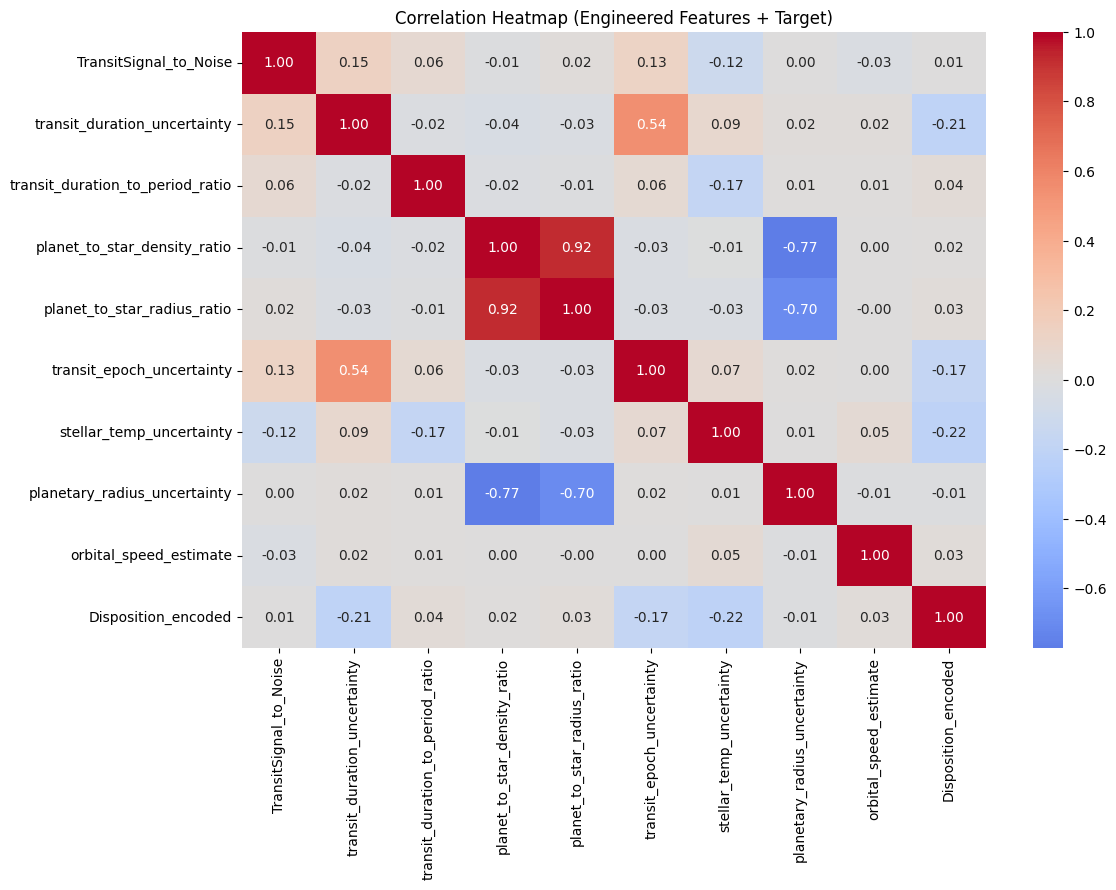

In [22]:
features_to_check = [
    'TransitSignal_to_Noise',
    'transit_duration_uncertainty',
    'transit_duration_to_period_ratio',
    'planet_to_star_density_ratio',
    'planet_to_star_radius_ratio',
    'transit_epoch_uncertainty',
    'stellar_temp_uncertainty',
    'planetary_radius_uncertainty',
    'orbital_speed_estimate',
    'Disposition_encoded'
]

plt.figure(figsize=(12,8))
sns.heatmap(df[features_to_check].corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Engineered Features + Target)")
plt.show()


In [23]:
df.head()

,Exoplanet_Archive_Disposition,TransitEpoch_BKJD,ImpactParameter,TransitDuration_hrs,EquilibriumTemperature_K,TransitSignal_to_Noise,StellarEffectiveTemperature_K,StellarSurfaceGravity,Kepler_band[mag],Disposition_encoded,...,transit_epoch_uncertainty,transit_frequency,planet_to_star_radius_ratio,planet_to_star_density_ratio,transit_duration_to_period_ratio,orbital_speed_estimate,combined_uncertainty_score,log_OrbitalPeriod_days,log_InsolationFlux_Earthflux,log_TransitDepth_ppm
0,CONFIRMED,170.538750,0.146,2.95750,793.0,35.8,5455.0,4.467,15.347,0,...,-0.004320,0.105396,2.437972,14.490592,0.311708,0.313440,-24.846806,2.350235,4.549552,6.424869
1,CONFIRMED,162.513840,0.586,4.50700,443.0,25.8,5455.0,4.467,15.347,0,...,-0.007040,0.018376,3.052859,28.452479,0.082821,0.205680,-23.906654,4.014911,2.313525,6.775366
2,CANDIDATE,175.850252,0.969,1.78220,638.0,76.3,5853.0,4.544,15.436,2,...,-0.001162,0.050253,16.820276,4758.821246,0.089562,0.487038,-72.856333,3.039708,3.696351,9.287394
3,FALSE POSITIVE,170.307565,1.276,2.40641,1395.0,505.6,5805.0,4.564,15.597,1,...,-0.000230,0.575721,42.300885,75691.717427,1.385421,0.328705,-126.793697,1.006845,6.794542,8.997271
4,CONFIRMED,171.595550,0.701,1.65450,1406.0,40.9,6031.0,4.438,15.509,0,...,-0.002260,0.395947,2.629063,18.172013,0.655094,0.632215,-160.514625,1.260048,6.832126,6.403574


In [24]:
df['Exoplanet_Archive_Disposition'].value_counts()

Exoplanet_Archive_Disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

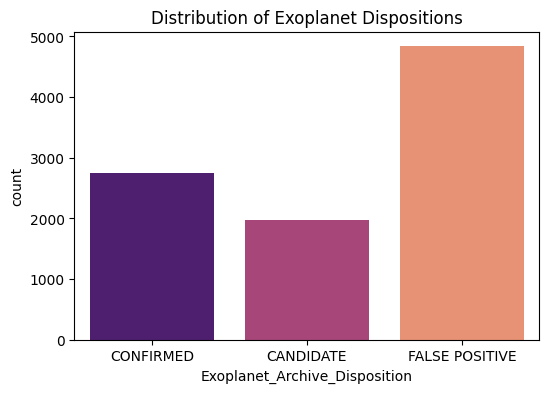

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x='Exoplanet_Archive_Disposition', data=df, palette='magma')
plt.title('Distribution of Exoplanet Dispositions')
plt.show()

In [26]:
X = df.drop(['Exoplanet_Archive_Disposition','Disposition_encoded'], axis=1)
y = df['Exoplanet_Archive_Disposition']


## Encoding the target labels

In [27]:
le = LabelEncoder()
y = le.fit_transform(y)


In [28]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (6694, 27) (6694,)
Validation shape: (1435, 27) (1435,)
Test shape: (1435, 27) (1435,)


## Baseline model RandomForest 

Random Forest Baseline Results
----------------------------------------
Validation Accuracy: 0.772
Test Accuracy:       0.803

Classification Report (Validation Set):

              precision    recall  f1-score   support

           0       0.54      0.45      0.49       297
           1       0.83      0.83      0.83       412
           2       0.82      0.87      0.84       726

    accuracy                           0.77      1435
   macro avg       0.73      0.72      0.72      1435
weighted avg       0.76      0.77      0.77      1435



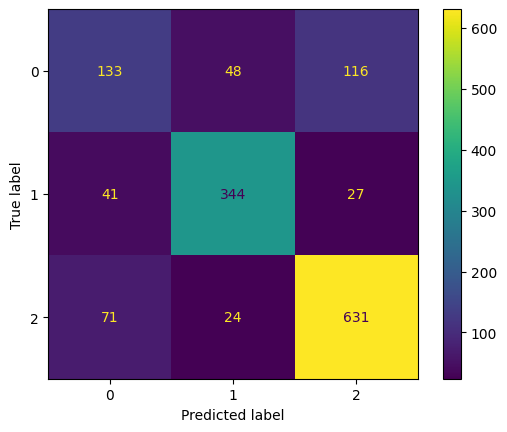

In [29]:
rf_baseline = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_baseline.fit(X_train, y_train)

y_val_pred = rf_baseline.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

y_test_pred = rf_baseline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Random Forest Baseline Results")
print("-" * 40)
print(f"Validation Accuracy: {val_acc:.3f}")
print(f"Test Accuracy:       {test_acc:.3f}\n")

print("Classification Report (Validation Set):\n")
print(classification_report(y_val, y_val_pred))

# Confusion matrix for validation set
ConfusionMatrixDisplay.from_estimator(rf_baseline, X_val, y_val)


## Training tuned Random Forest

In [30]:
rmf = RandomForestClassifier(
    n_estimators=250,
    max_depth=20,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rmf.fit(X_train, y_train)

y_val_pred = rmf.predict(X_val)
print("Validation Report (Tuned RF):\n")
print(classification_report(y_val, y_val_pred))

y_test_pred = rmf.predict(X_test)
print("\nTest Report (Tuned RF):\n")
print(classification_report(y_test, y_test_pred))


Validation Report (Tuned RF):

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       297
           1       0.82      0.84      0.83       412
           2       0.82      0.86      0.84       726

    accuracy                           0.77      1435
   macro avg       0.73      0.72      0.73      1435
weighted avg       0.77      0.77      0.77      1435


Test Report (Tuned RF):

              precision    recall  f1-score   support

           0       0.64      0.52      0.57       297
           1       0.86      0.85      0.86       412
           2       0.83      0.89      0.86       726

    accuracy                           0.80      1435
   macro avg       0.77      0.76      0.76      1435
weighted avg       0.80      0.80      0.80      1435



### cleaning the columns 

In [31]:
# Clean column names for all sets
def clean_columns(df):
    df = df.copy()
    df.columns = [str(c).replace('[','')
                            .replace(']','')
                            .replace('<','')
                            .replace(' ','_') for c in df.columns]
    return df

X_train = clean_columns(X_train)
X_val   = clean_columns(X_val)
X_test  = clean_columns(X_test)


## training xgboost model first

In [32]:
xgb = XGBClassifier(
    n_estimators=250,
    max_depth=20,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)
xgb.fit(X_train, y_train)

# Validation performance
y_val_pred_xgb = xgb.predict(X_val)
y_val_proba_xgb = xgb.predict_proba(X_val)
print("XGBoost Validation Report:\n")
print(classification_report(y_val, y_val_pred_xgb))
print("ROC AUC (ovr):", roc_auc_score(y_val, y_val_proba_xgb, multi_class='ovr'))
print("PR AUC (macro):", average_precision_score(y_val, y_val_proba_xgb, average='macro'))

# Test performance 
y_test_pred_xgb = xgb.predict(X_test)
y_test_proba_xgb = xgb.predict_proba(X_test)
print("\nXGBoost Test Report:\n")
print(classification_report(y_test, y_test_pred_xgb))
print("ROC AUC (ovr):", roc_auc_score(y_test, y_test_proba_xgb, multi_class='ovr'))
print("PR AUC (macro):", average_precision_score(y_test, y_test_proba_xgb, average='macro'))

XGBoost Validation Report:

              precision    recall  f1-score   support

           0       0.57      0.47      0.52       297
           1       0.84      0.86      0.85       412
           2       0.83      0.87      0.85       726

    accuracy                           0.79      1435
   macro avg       0.75      0.74      0.74      1435
weighted avg       0.78      0.79      0.78      1435

ROC AUC (ovr): 0.9100866634582606
PR AUC (macro): 0.797773634976723

XGBoost Test Report:

              precision    recall  f1-score   support

           0       0.64      0.52      0.57       297
           1       0.86      0.89      0.87       412
           2       0.84      0.89      0.86       726

    accuracy                           0.81      1435
   macro avg       0.78      0.76      0.77      1435
weighted avg       0.80      0.81      0.81      1435

ROC AUC (ovr): 0.9268797038408266
PR AUC (macro): 0.8407733199548463


## Lightgbm model

In [33]:
lgbm = LGBMClassifier(
    n_estimators=250,
    max_depth=20,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

# Validation performance
y_val_pred_lgbm = lgbm.predict(X_val)
y_val_proba_lgbm = lgbm.predict_proba(X_val)
print("\nLightGBM Validation Report:\n")
print(classification_report(y_val, y_val_pred_lgbm))
print("ROC AUC (ovr):", roc_auc_score(y_val, y_val_proba_lgbm, multi_class='ovr'))
print("PR AUC (macro):", average_precision_score(y_val, y_val_proba_lgbm, average='macro'))

# Test performance
y_test_pred_lgbm = lgbm.predict(X_test)
y_test_proba_lgbm = lgbm.predict_proba(X_test)
print("\nLightGBM Test Report:\n")
print(classification_report(y_test, y_test_pred_lgbm))
print("ROC AUC (ovr):", roc_auc_score(y_test, y_test_proba_lgbm, multi_class='ovr'))
print("PR AUC (macro):", average_precision_score(y_test, y_test_proba_lgbm, average='macro'))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6853
[LightGBM] [Info] Number of data points in the train set: 6694, number of used features: 27
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

LightGBM Validation Report:

              precision    recall  f1-score   support

           0       0.51      0.57      0.54       297
           1       0.83      0.87      0.85       412
           2       0.87      0.80      0.83       726

    accuracy                           0.77      1435
   macro avg       0.74      0.75      0.74      1435
weighted avg       0.78      0.77      0.78      1435

ROC AUC (ovr): 0.9088184248746805
PR AUC (macro): 0.7944638146324685

LightGBM Test Report:

              precision    recall  f1-score   

## Hyperparameter Tuning with RandomizedSearchCV

After training baseline models (LightGBM, XGBoost, Random Forest) with fixed parameters,  
the next step is to optimize their performance through hyperparameter tuning.  

We use **RandomizedSearchCV** to efficiently explore a wide range of parameter combinations 
for both LightGBM and XGBoost. This approach balances computational cost with the ability 
to identify strong parameter sets that improve recall and overall classification metrics.  

The search is performed on the training set with cross-validation, and the best estimator 
is then evaluated on the validation set to confirm improvements over the baseline.


In [34]:
param_grid_xgb = {
    'n_estimators': [200, 300, 400],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 5] 
}

xgb_search = RandomizedSearchCV(
    estimator = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    param_distributions = param_grid_xgb,
    n_iter = 20,
    scoring = 'f1_macro',
    cv = 3,
    verbose = 2,
    random_state = 42,
    n_jobs = -1
)

# Fit only on raw training data (70%)
xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)

# Evaluating on validation set
best_xgb = xgb_search.best_estimator_
y_val_pred = best_xgb.predict(X_val)
print("\nValidation Report (best XGB):\n", classification_report(y_val, y_val_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB params: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

Validation Report (best XGB):
               precision    recall  f1-score   support

           0       0.57      0.48      0.53       297
           1       0.84      0.87      0.85       412
           2       0.84      0.88      0.86       726

    accuracy                           0.79      1435
   macro avg       0.75      0.74      0.75      1435
weighted avg       0.78      0.79      0.79      1435



In [35]:
#Final Test Evaluation
y_test_pred = best_xgb.predict(X_test)
y_test_proba = best_xgb.predict_proba(X_test)

print("\nXGBoost Test Report (best tuned):\n")
print(classification_report(y_test, y_test_pred))
print("ROC AUC (ovr):", roc_auc_score(y_test, y_test_proba, multi_class='ovr'))
print("PR AUC (macro):", average_precision_score(y_test, y_test_proba, average='macro'))



XGBoost Test Report (best tuned):

              precision    recall  f1-score   support

           0       0.61      0.51      0.56       297
           1       0.86      0.88      0.87       412
           2       0.83      0.87      0.85       726

    accuracy                           0.80      1435
   macro avg       0.77      0.76      0.76      1435
weighted avg       0.79      0.80      0.80      1435

ROC AUC (ovr): 0.9261214728872617
PR AUC (macro): 0.8383868527822397


## Tuned Lightgbm model

In [ ]:
param_grid_lgbm = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [6, 10, 15, -1],          
    'num_leaves': [31, 63, 127],           
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_samples': [10, 20, 30, 50],
    'class_weight': [None, 'balanced']     
}

lgbm_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_grid_lgbm,
    n_iter=25,               
    scoring='f1_macro',       
    cv=3,                   
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit only on raw training data (70%)
lgbm_search.fit(X_train, y_train)

print("Best LGBM params:", lgbm_search.best_params_)

# Evaluating on validation set
best_lgbm = lgbm_search.best_estimator_
y_val_pred = best_lgbm.predict(X_val)
print("\nValidation Report :\n", classification_report(y_val, y_val_pred))


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6853
[LightGBM] [Info] Number of data points in the train set: 6694, number of used features: 27
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best LGBM params: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'class_weight': 'balanced'}

Validation Report :
               precision    recall  f1-score   support

           0       0.50      0.61      0.55       297
           1       0.84      0.85      0.85       412
           2       0.88      0.79      0.83       726

    accuracy                           0.77      1435
 

In [ ]:
y_test_pred_lgbm = best_lgbm.predict(X_test)
y_test_proba_lgbm = best_lgbm.predict_proba(X_test)

print("\nLightGBM Test Report (best tuned):\n")
print(classification_report(y_test, y_test_pred_lgbm))
print("ROC AUC (ovr):", roc_auc_score(y_test, y_test_proba_lgbm, multi_class='ovr'))
print("PR AUC (macro):", average_precision_score(y_test, y_test_proba_lgbm, average='macro'))

In [ ]:
import joblib
joblib.dump(best_lgbm, "lightgbm_exoplanet_model.pkl")


In [ ]:
import joblib
joblib.dump(le, "label_encoder.pkl")


# extracting info for the web interface`

In [ ]:
list(X_train.columns)